In [1]:
options(repr.matrix.max.cols=50)

In [3]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(gridExtra)
library(ggpubr)

- Read the data

In [4]:
meta <- readRDS(paste0(TMP_DIR, "validation-hmf-go.Rds")) %>% drop_na(tcell) %>% select(patient_id, tissue_full) 
hmf <- readRDS(paste0(TMP_DIR, "validation-loo-cv.Rds"))
non_hmf <- readRDS(paste0(TMP_DIR, "validation-non-cpi.Rds"))

- Let's go!

In [6]:
hmf_go <- ( meta 
      %>% inner_join( hmf, by = "patient_id")
      %>% transmute( cpi = TRUE, lr_gp, tissue_full))
go <- rbind( hmf_go, non_hmf %>% transmute(cpi, lr_gp, tissue_full))

In [7]:
o_dir <- paste0(FIG_DIR ,"supplement_main/")

In [8]:
namer <- function(i){str_to_title(paste0(strsplit(i, "_")[[1]], collapse = " "))}
go$tissue_full <- unlist(lapply(as.character(go$tissue_full), function(i) namer(i)))
go$tissue_full <- ifelse(go$cpi, paste0(" ", go$tissue_full), go$tissue_full)

In [9]:
base <- ( go 
    %>% group_by(tissue_full, cpi) 
    %>% mutate(ct = n())
    %>% ungroup()
    %>% mutate(tissue_gp = ifelse(ct < 15, "Other", tissue_full)) #ifelse(ct < 5, "other", tissue_full))
    #%>% group_by(tissue_go, lr_gp, cpi)
    #%>% summarise( tot = n())
)

In [10]:
top <- base %>% group_by(tissue_gp, lr_gp, cpi) %>% summarise(tot = n())
bottom <- base %>% filter(tissue_gp == "Other") %>% group_by(tissue_full, lr_gp, cpi) %>% summarise(tot = n())

`summarise()` has grouped output by 'tissue_gp', 'lr_gp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'tissue_full', 'lr_gp'. You can override using the `.groups` argument.


### Plots go

In [11]:
top$cpi_go <- ifelse(top$cpi, "CPI", "Non-CPI")
top <- top %>% group_by(cpi) %>% arrange(tot)

bottom$cpi_go <- ifelse(bottom$cpi, "CPI", "Non-CPI")
bottom <- bottom %>% group_by(cpi) %>% arrange(tot)

In [12]:
idx_top <- top %>% arrange(tissue_gp) %>% group_by(tissue_gp) %>% summarise(ct = sum(tot)) %>% arrange(ct) %>% pull(tissue_gp)
idx_bottom <- bottom %>% arrange(tissue_full) %>% group_by(tissue_full) %>% summarise(ct = sum(tot)) %>% arrange(ct) %>% pull(tissue_full)

In [13]:
idx_top <- c("Other", idx_top[-which(idx_top == "Other")])
#idx_bottom <- c(idx_bottom[-which(idx_bottom == "Other")], "Other")

In [14]:
top <- top %>% mutate( tissue_gp = factor(tissue_gp, levels = idx_top))
bottom <- bottom %>% mutate( tissue_full = factor(tissue_full, levels = idx_bottom))

In [15]:
dist_plotter <- function(df, theme, gp = "tissue_gp", title = "Predicted CPI Response Groups") {
    (
    ggplot(data = df, aes_string(y= gp, x="tot", fill = "lr_gp", label = "tot"), colour="black", stat="identity") 
    + geom_bar(stat="identity", width=.9, position = 'stack', colour = "black", size = .1) 
    + scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))    
    + geom_text(size = 4.4, position = position_stack(vjust = .5))
    + theme
    + labs(y = "Primary Tissue\n")
    + facet_grid( rows = vars(cpi_go), scales = "free", space = "free")
    + ggtitle( title )
    )
}
annote <- function( i, lab, size = 20 ) annotate_figure( i, fig.lab = lab, fig.lab.size = size, fig.lab.face = "bold")

In [16]:
base_theme <- (
    theme_classic(base_size = 23)
)

theme_dist <- (
    base_theme + 
    theme(
          axis.ticks.x = element_blank(), 
          axis.text.x = element_blank(),
          axis.line.x = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_text(margin = margin(t = 200)),
          plot.margin = unit(c(1,0,0,1.5), "cm"),
          plot.title = element_text(hjust = .5, size = 20),
          legend.position = c(.7, .3),
          legend.text = element_text(colour="black", size=20),
          legend.title=element_blank()
         )
)
go_top <- dist_plotter(top, theme = theme_dist)
go_bottom <- dist_plotter(bottom, theme = theme_dist, gp = "tissue_full", title = "(Other) Predicted CPI Response Groups")
#saveRDS( annote(go_go, "A"), paste0(FIG_DIR, "pred_non_hmf.Rds"))

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [17]:
options(repr.plot.width=14, repr.plot.height=14)
go <- as_ggplot( arrangeGrob( go_top, go_bottom, layout_matrix = cbind(c(1,1,1,1,1,1,1,2,2,2,2,2,2))) )
#go_bottom

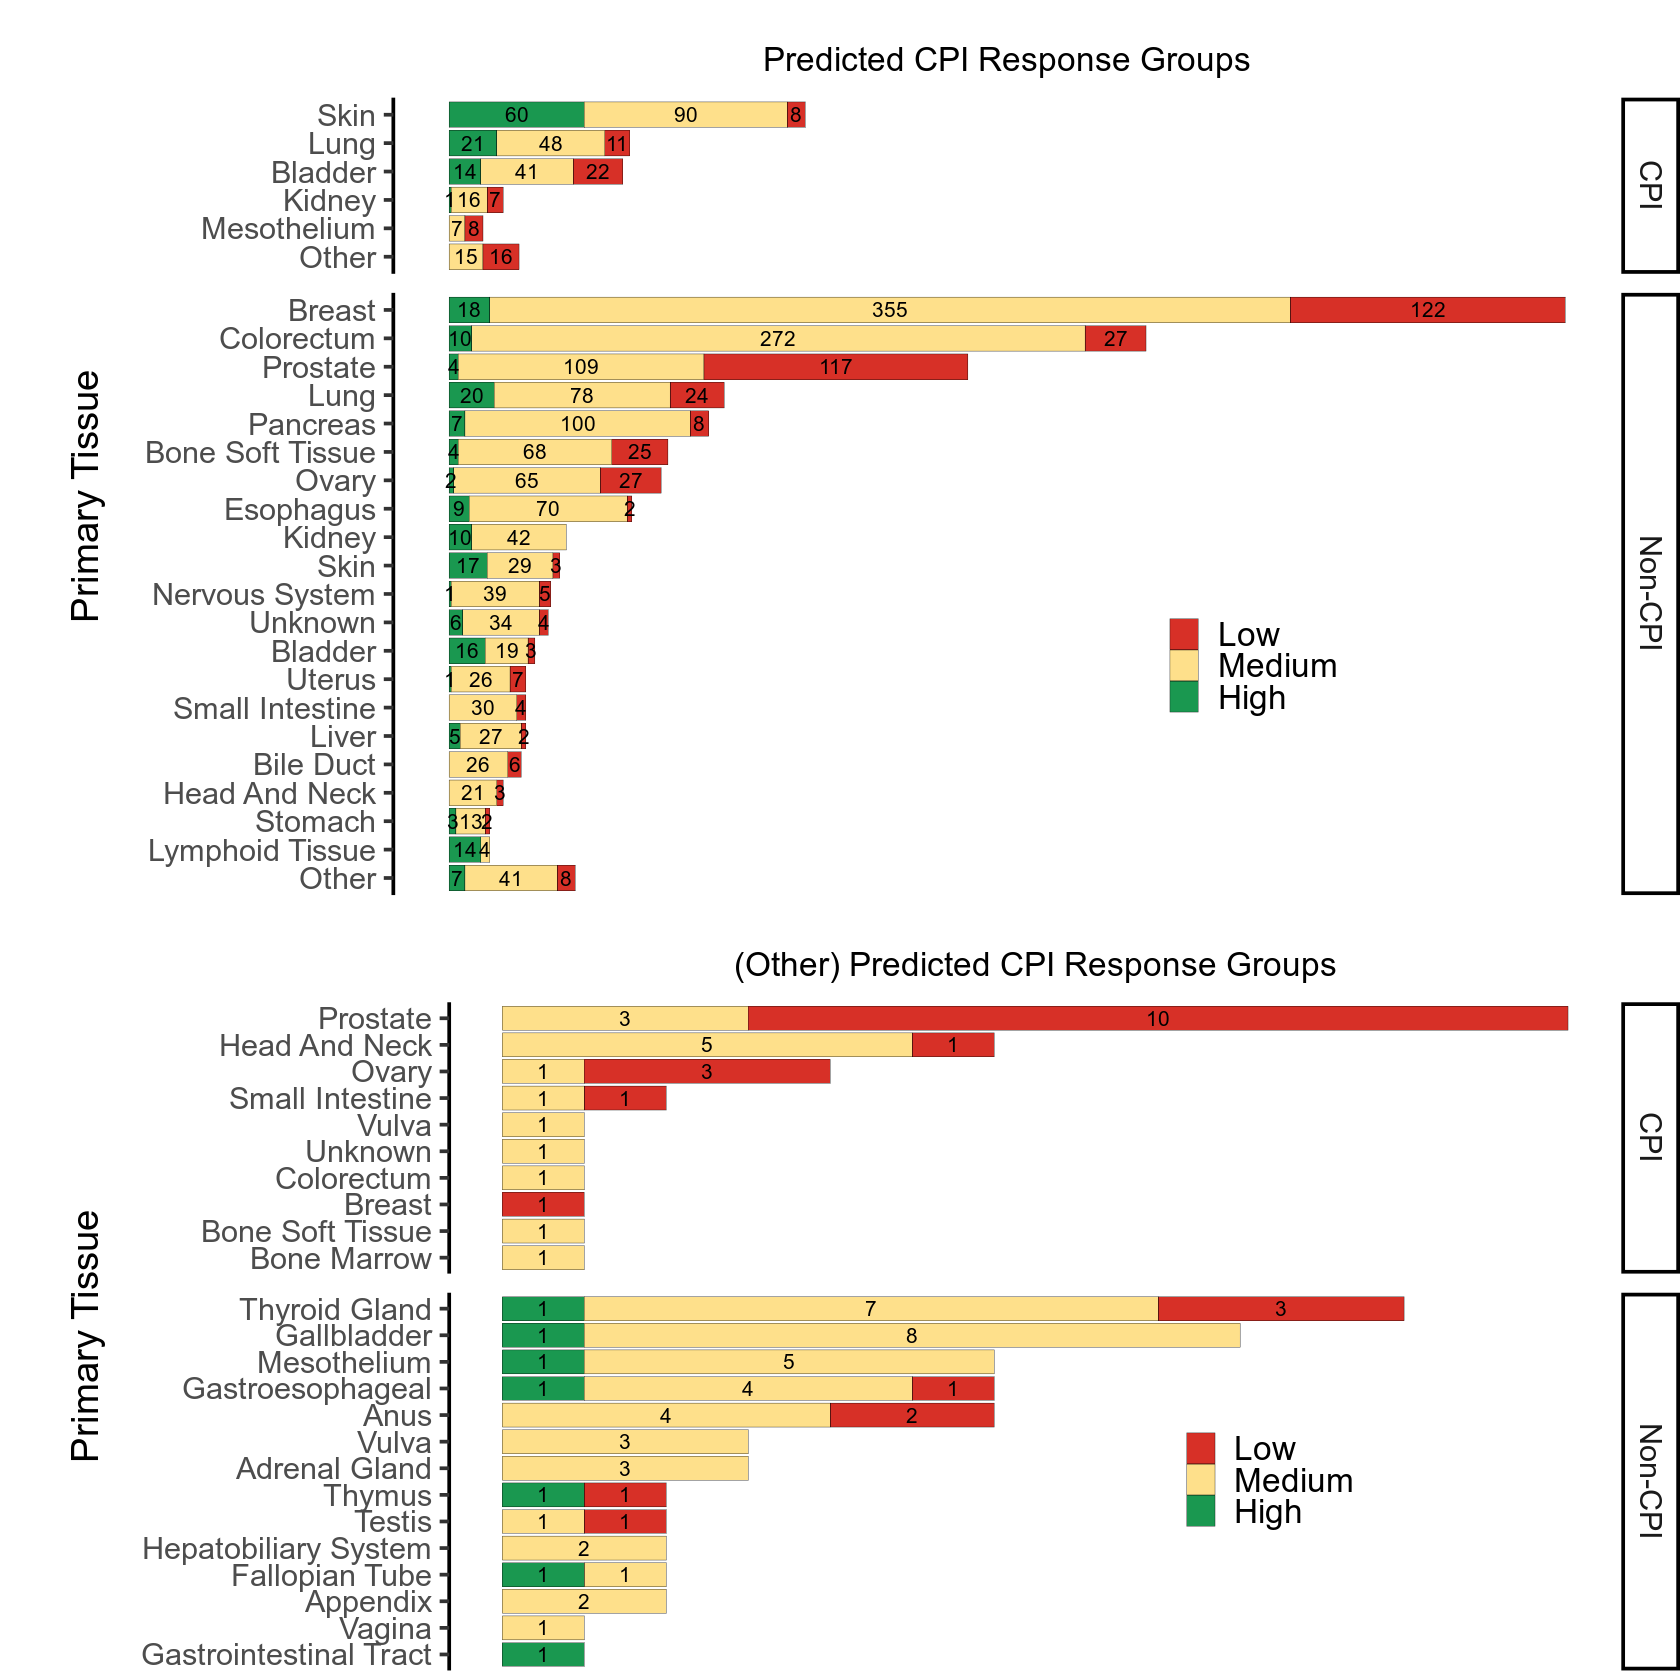

In [18]:
go

In [ ]:
options(repr.plot.width=14, repr.plot.height=14)
go
ggsave( paste0(FIG_FINAL_DIR, "3_supplement_main_hmf_non_cpi_preds.png"), width = 14, height = 14, dpi = 500)